In [399]:
import pickle
import pandas as pd
import numpy as np

from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix, accuracy_score, log_loss, precision_score,\
recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.dummy import DummyClassifier

from ipywidgets import interactive, FloatSlider
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.max_columns = 80

In [381]:
with open('google_feature_engineering.pkl', 'rb') as f:
    df = pickle.load(f)

In [382]:
model_features = [
'purchased_or_not',
'log_hits',
'log_pageviews',
'log_timeOnSite',
'log_visitNumber',
'action_type',
'totals.newVisits',
'totals.bounces',
'high_channelGrouping',
'high_trafficSource.isTrueDirect',
'high_device.operatingSystem',
'high_geoNetwork.metro',
'high_geoNetwork.networkDomain',
'low_trafficSource.source',
'low_geoNetwork.continent',
'low_geoNetwork.networkDomain',
'low_geoNetwork.region',
'low_geoNetwork.subContinent',
'bot_traffic']
df=df[model_features]

In [383]:
X = df.drop(columns = ["purchased_or_not"])
y = df["purchased_or_not"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(X_train,y_train)

In [315]:
# checking feature importance

bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                            Specs          Score
4                     action_type  446548.538598
2                  log_timeOnSite  100518.122954
0                        log_hits   42698.717766
1                   log_pageviews   38502.153212
7            high_channelGrouping   11980.641610
10          high_geoNetwork.metro    8762.685725
11  high_geoNetwork.networkDomain    6344.802812
17                    bot_traffic    6065.456156
6                  totals.bounces    5816.369721
9     high_device.operatingSystem    4200.621378


# All Models comparison

In [186]:
def classification_models(X_train, X_test, y_train, y_test):
    
    models = {
    "KNN": KNeighborsClassifier(n_neighbors=1),
    "Logistic": LogisticRegression(solver="lbfgs",random_state = 42),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(gamma="auto", probability=True, random_state = 42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    for key in models.keys():
        model_fit = models[key].fit(X_train, y_train)
        model_accuracy = accuracy_score(y_test, models[key].predict(X_test))
        model_precision = precision_score(y_test, models[key].predict(X_test))
        model_recall = recall_score(y_test, models[key].predict(X_test))
        model_f1 = f1_score(y_test, models[key].predict(X_test))
        print("\nModel: {key}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\n"\
             .format(key=str(key), accuracy=str(model_accuracy), precision=str(model_precision), recall=str(model_recall), f1=str(model_f1)))
        
    plt.figure(figsize = (12,8))
    plt.plot([0,1],[0,1],ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])


    for key in models.keys():
        fpr, tpr, thresholds = roc_curve(y_test, models[key].predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr,lw=2, label=key) 
        print(key, "ROC AUC score:", roc_auc_score(y_test, models[key].predict_proba(X_test)[:, 1]))

    plt.legend(loc=0)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')


Model: KNN
Accuracy: 0.9843690346426457
Precision: 0.4507843137254902
Recall: 0.9896685320705984
F1: 0.6194261080425704


Model: Logistic
Accuracy: 0.9884469183482635
Precision: 0.5266742338251986
Recall: 0.9987085665088248
F1: 0.689655172413793


Model: Naive Bayes
Accuracy: 0.9900238475967045
Precision: 0.5634455832113225
Recall: 0.9939733103745158
F1: 0.7192026164148886


Model: SVM
Accuracy: 0.9874564961185408
Precision: 0.506108202443281
Recall: 0.9987085665088248
F1: 0.6717822498914144


Model: Decision Tree
Accuracy: 0.9883749882421942
Precision: 0.5255172413793103
Recall: 0.9840723202755058
F1: 0.6851491083470702


Model: Random Forest
Accuracy: 0.9889614952609126
Precision: 0.5380510440835267
Recall: 0.998278088678433
F1: 0.6992311171415648

KNN ROC AUC score: 0.9869842817296627
Logistic ROC AUC score: 0.9963508891757883
Naive Bayes ROC AUC score: 0.994699312219928
SVM ROC AUC score: 0.9952348916633368
Decision Tree ROC AUC score: 0.9862516661688727
Random Forest ROC AUC scor

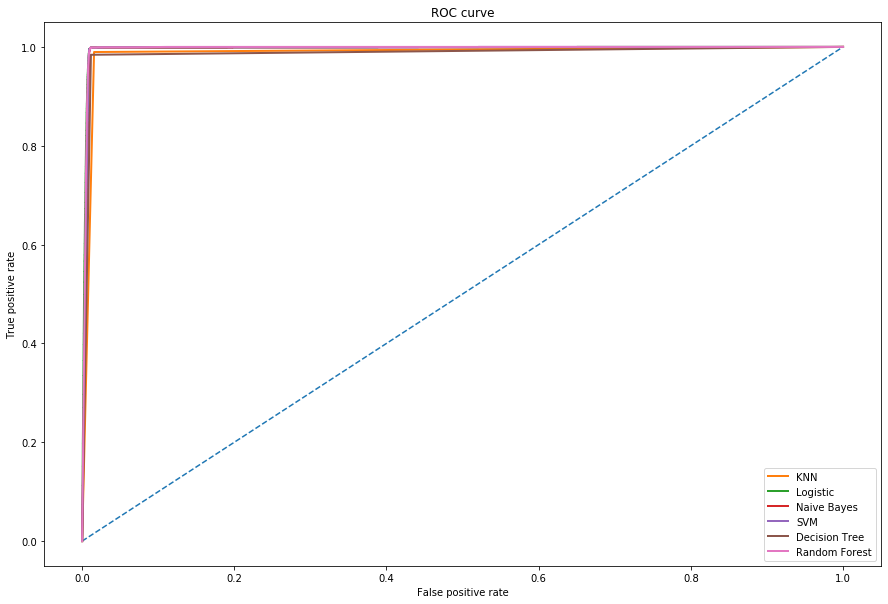

In [187]:
classification_models(X_under, X_test, y_under, y_test)

Because of the 1:40 class imbanlance, the ROC AUC score is not a good metric.

KNN and SVC takes significant amount of run time as dataset scales up, I will look into four other models used under sample train set to speed up the training

# Naive Bayes

In [288]:
def evaluate_model(model):
    print_model_metrics(model, "train", X_train, y_train)
    print_model_metrics(model, "test", X_test, y_test)

def print_model_metrics(model, dataset, X, y):
    y_pred = model.predict(X)
    model_accuracy = accuracy_score(y, y_pred)
    model_precision = precision_score(y, y_pred)
    model_recall = recall_score(y, y_pred)
    model_f1 = f1_score(y, y_pred)
    print("\n{dataset} set\nModel: {model}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}"\
         .format(dataset = dataset, model=str(model).split("(")[0], accuracy=str(round(model_accuracy, 4)),\
                 precision=str(round(model_precision, 4)), recall=str(round(model_recall, 4)), f1=str(round(model_f1, 4)) ))

In [289]:
# fit and evaluate
nb = GaussianNB()
nb.fit(X_train, y_train)

evaluate_model(nb)


train set
Model: GaussianNB
Accuracy: 0.9907
Precision: 0.5789
Recall: 0.9915
F1: 0.731

test set
Model: GaussianNB
Accuracy: 0.9902
Precision: 0.5686
Recall: 0.9935
F1: 0.7233


Compare the train and test set scores we see there is no overfitting

In [189]:
def make_confusion_matrix(model, threshold=0.5):
    from sklearn.metrics import confusion_matrix
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=160)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d', cbar=False,
           xticklabels=['not_buying', 'buying'],
           yticklabels=['not_buying', 'buying']);
    plt.yticks(rotation=0)
    plt.xlabel('prediction')
    plt.ylabel('actual', rotation=0) 
    plt.title(str(model).split("(")[0]+" confusion matrix", fontsize=15)
#     plt.savefig('confusion_matrix.png', transparent=True)

In [190]:
interactive(lambda threshold: make_confusion_matrix(nb, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

Tuning the threshold does not change the FP and FN in confusion matrix and therefore cannot improve model performance. Consider using other models

# Decision Tree

In [26]:
# tuning hyperparameters in DT model, through grid search finding the optimal max_depth, min_samples and max_features
# run the code with different values in param_grid to narrow down the best parameter

tree = DecisionTreeClassifier(random_state = 42)
param_grid = dict(max_depth = [8, 9, 10], 
                  min_samples_leaf = [2, 3, 4], 
                  max_features = [None]
                 )

# mean accuracy across all folds used as scoring metric
grid = GridSearchCV(tree, param_grid, cv = 5, scoring = 'accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [8, 9, 10], 'max_features': [None],
                         'min_samples_leaf': [2, 3, 4]},
       

In [291]:
print(round(grid.best_score_, 4))  
print(grid.best_params_) 
print(grid.best_estimator_)

0.993
{'max_depth': 9, 'max_features': None, 'min_samples_leaf': 4}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')


In [290]:
# fit decision tree model and evaluate

tree = DecisionTreeClassifier(random_state=42, max_depth=9, min_samples_split=3, max_features=9)
tree.fit(X_train, y_train)

evaluate_model(tree)


train set
Model: DecisionTreeClassifier
Accuracy: 0.9934
Precision: 0.6911
Recall: 0.8658
F1: 0.7686

test set
Model: DecisionTreeClassifier
Accuracy: 0.9927
Precision: 0.6669
Recall: 0.8644
F1: 0.7529


In [191]:
interactive(lambda threshold: make_confusion_matrix(tree, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

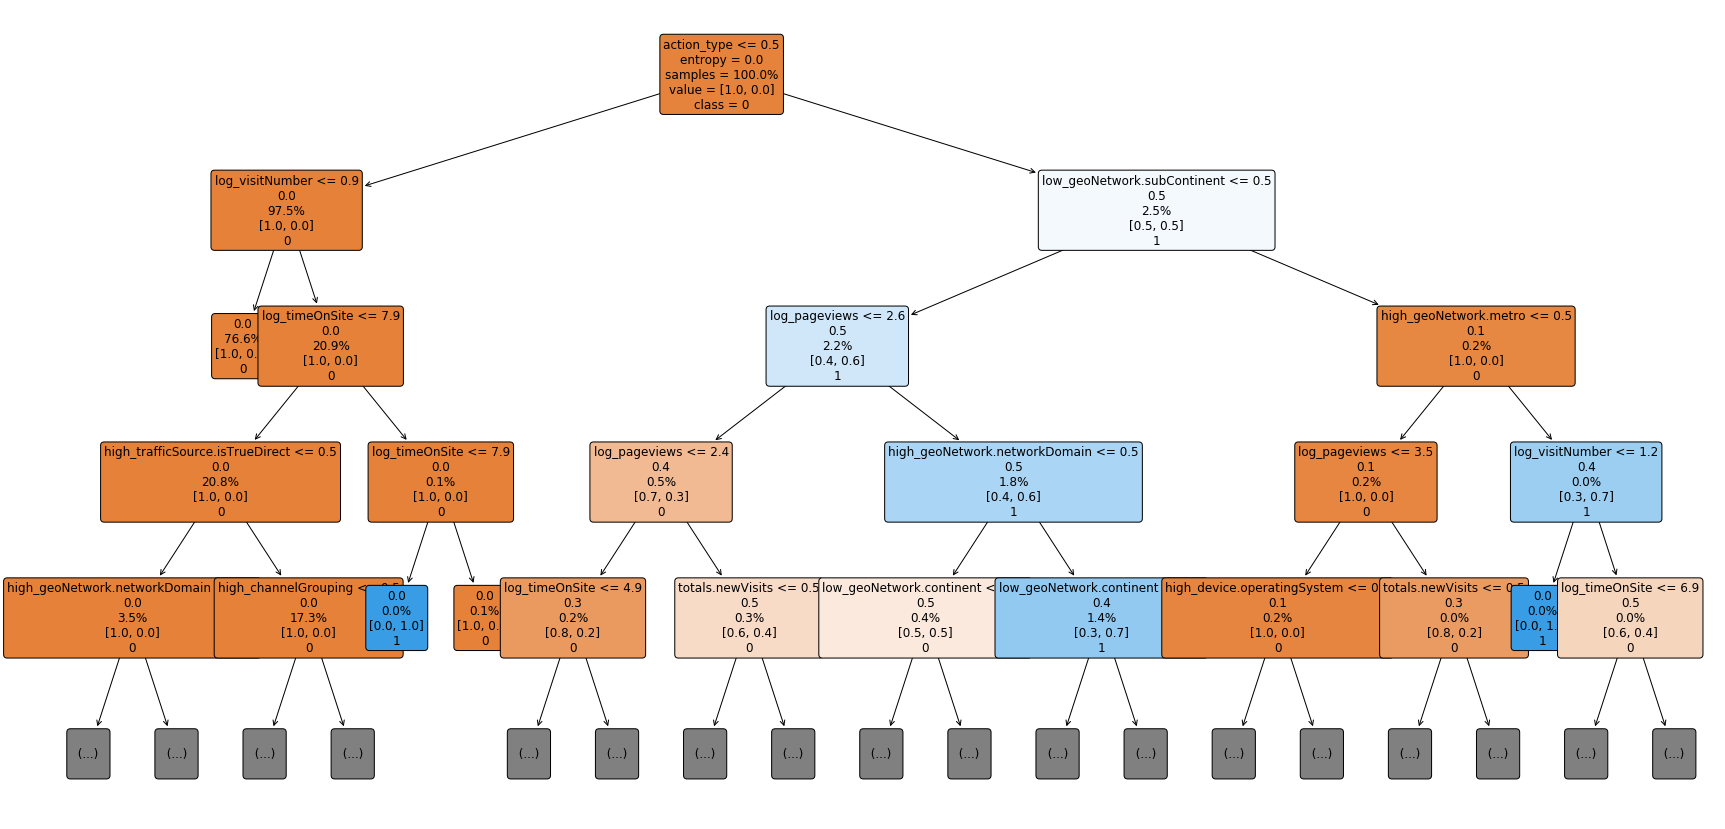

In [29]:
# plot decision tree showing split, entropy, % of samples, fraction in each branch, and class for each node

plt.figure(figsize = (30, 15))
plot_tree(tree, feature_names = list(X.columns), max_depth = 4,
          class_names = [str(i) for i in tree.classes_], filled = True, proportion = True, 
          rounded = True, precision = 1, fontsize = 12, label = 'root')
# plt.savefig('decision_tree.png', dpi = 100)
plt.show()
plt.close()

From the root node, following the white/blue box, the classifer identifies the buying visitor at each split based on: 
1. action_type: viewed chechout page
2. geo_location: not on low purchase rate subcontinent(see feature selection notebook for details)
3. page views: more log page view than 2.6(or more than 13.46 page views during visit section)
4. network domain: visited from high purchase rate network domain 
5. ...

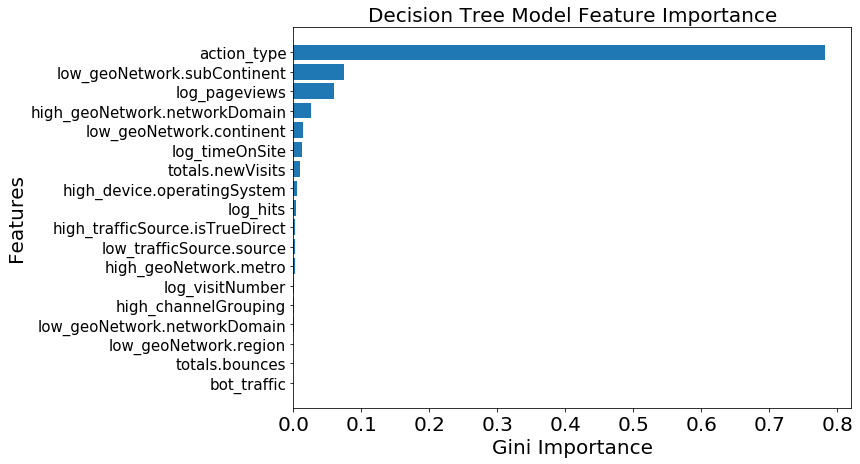

In [61]:
# Feature Gini importance

feat_imp = pd.DataFrame({'features': X.columns, 'importance': tree.feature_importances_})\
                    .sort_values('importance')

plt.figure(figsize = (10, 7))
plt.barh(feat_imp['features'], feat_imp['importance'])
plt.title("Decision Tree Model Feature Importance", fontsize = 20)
plt.xlabel("Gini Importance", fontsize = 20)
plt.ylabel("Features", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 15)

# plt.savefig('tree_feat_importance.png', dpi = 100)
plt.show()
plt.close()

Form the chart we can see action_type(whether the visitor clicked into the checkout page) is the most important feature when predicting customer purchase.

# Random Forest

In [248]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 35, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [9, 10, 11]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(8, 15, num = 7)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 15, cv = 3, verbose=1, random_state=42)

rf_random.fit(X_train, y_train)

In [239]:
# best parameters through randomized grid search. To avoid overfitting, I have adjusted the parameters

rf_random.best_params_

{'n_estimators': 35,
 'min_samples_split': 11,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 13,
 'bootstrap': False}

In [292]:
rf = RandomForestClassifier(n_estimators=33, min_samples_split=11, min_samples_leaf=2,\
                            max_features="sqrt", max_depth=9, bootstrap=True, random_state = 42)
rf.fit(X_train, y_train)

evaluate_model(rf)


train set
Model: RandomForestClassifier
Accuracy: 0.9935
Precision: 0.7109
Recall: 0.823
F1: 0.7628

test set
Model: RandomForestClassifier
Accuracy: 0.9927
Precision: 0.6806
Recall: 0.8145
F1: 0.7415


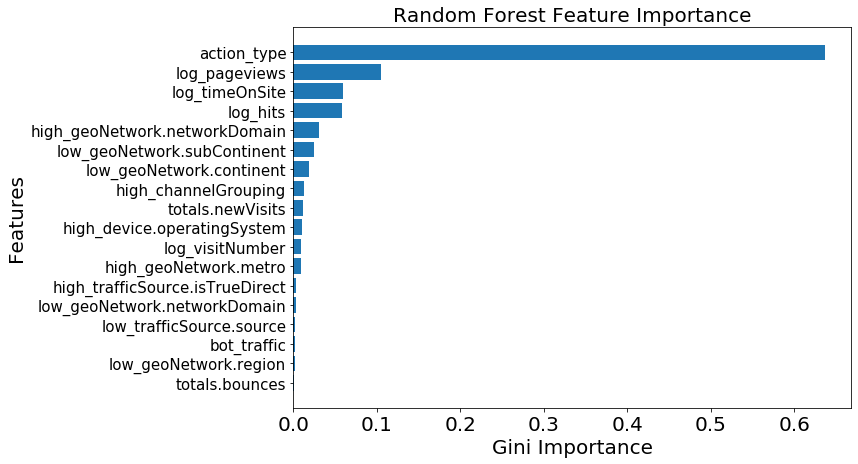

In [254]:
# Feature importance

feat_imp = pd.DataFrame({'features': X.columns, 'importance': rf.feature_importances_}).sort_values('importance')

plt.figure(figsize = (10, 7))
plt.barh(feat_imp['features'], feat_imp['importance'])
plt.title("Random Forest Feature Importance", fontsize = 20)
plt.xlabel("Gini Importance", fontsize = 20)
plt.ylabel("Features", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 15)

# plt.savefig('tree_feat_importance.png', dpi = 100)
plt.show()
plt.close()

# Logistic Regression

In [373]:
logreg = LogisticRegression(solver="warn", C=1, random_state=42)
logreg.fit(X_train, y_train)
evaluate_model(logreg)

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



train set
Model: LogisticRegression
Accuracy: 0.9933
Precision: 0.7002
Recall: 0.8232
F1: 0.7567

test set
Model: LogisticRegression
Accuracy: 0.9925
Precision: 0.6747
Recall: 0.8097
F1: 0.7361


In [258]:
interactive(lambda threshold: make_confusion_matrix(logreg, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

choose 0.3 as the threshold, as a result, recall score increases such that the model identifies 97% of the high value customers, on the other hand, precision score decreases, the false positive of this model identifies the potential customer.

In [336]:
y_predict = (logreg.predict_proba(X_test)[:,1] > 0.30)
print("Threshold of 0.30:")
print("Precision: {:6.4f} \nRecall: {:6.4f}".format(precision_score(y_test, y_predict), recall_score(y_test, y_predict)))

Threshold of 0.30:
Precision: 0.6137 
Recall: 0.9737


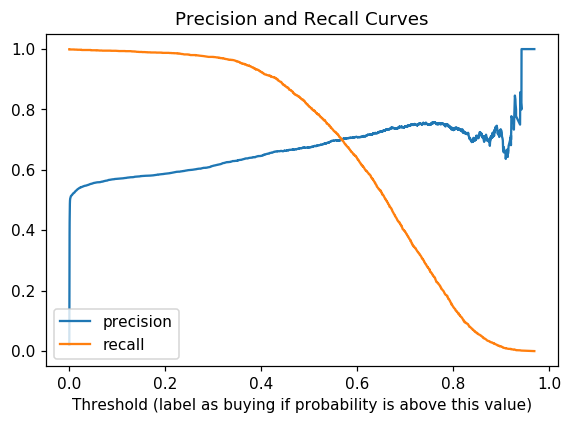

In [298]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, logreg.predict_proba(X_test)[:,1] )

plt.figure(dpi=110)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (label as buying if probability is above this value)')
plt.title('Precision and Recall Curves')
plt.show()

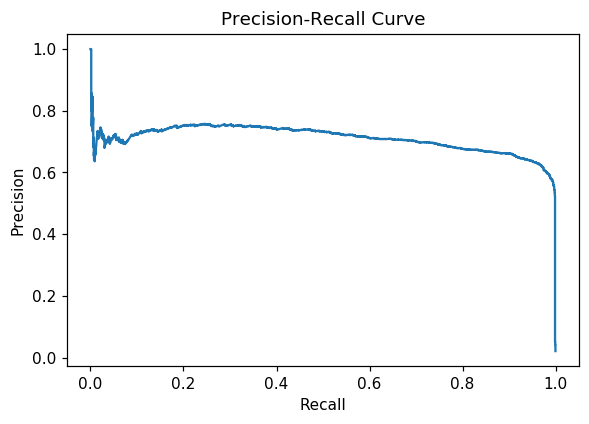

In [317]:
plt.figure(dpi=110)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [327]:
print("Log-loss on logit: {:6.4f}".format( log_loss(y_test, logreg.predict_proba(X_test) ) ) )

dc = DummyClassifier()
dc.fit(X_train, y_train)
print("Log-loss on dummy classifier: {:6.4f}".format(log_loss(y_test, dc.predict_proba(X_test) ) ) )

print("Logistic accuracy: {:6.4f}".format(logreg.score(X_test, y_test)))
print("Dummy accuracy: {:6.4f}".format(dc.score(X_test, y_test)))

Log-loss on logit: 0.0143
Log-loss on dummy classifier: 0.8812
Logistic accuracy: 0.9925
Dummy accuracy: 0.9746


In [329]:
# evaluate dummy classifier
evaluate_model(dc)


train set
Model: DummyClassifier
Accuracy: 0.9748
Precision: 0.0132
Recall: 0.0134
F1: 0.0133

test set
Model: DummyClassifier
Accuracy: 0.9745
Precision: 0.0128
Recall: 0.0129
F1: 0.0129


## Regularization

In [444]:
# feature selection through regularization

mask = [
# 'log_hits',
'log_pageviews',
# 'log_timeOnSite',
# 'log_visitNumber',
'action_type',
# 'totals.newVisits',
# 'totals.bounces',
# 'high_channelGrouping',
'high_trafficSource.isTrueDirect',
'high_device.operatingSystem',
# 'high_geoNetwork.metro',
'high_geoNetwork.networkDomain',
'low_trafficSource.source',
'low_geoNetwork.continent',
'low_geoNetwork.networkDomain',
'low_geoNetwork.region',
'low_geoNetwork.subContinent',
# "bot_traffic"
]

# standard transform all variables so that one can compare the coefficient between features and reduce model complexity
scaler = StandardScaler()
scaler.fit(X_train[mask])

logreg = LogisticRegression(solver="warn", C=1, random_state=42)
logreg.fit(scaler.transform(X_train[mask]), y_train)

print_model_metrics(logreg, "train", scaler.transform(X_train[mask]), y_train)
print_model_metrics(logreg, "test", scaler.transform(X_test[mask]), y_test)


print("\ncoefficient for logistic regression is: ")
coef_list = zip(X_train[mask].columns, list(np.around(logreg.coef_, decimals=2)[0]))
for i, j in coef_list:
    print(j, "\t<{}>".format(i))

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



train set
Model: LogisticRegression
Accuracy: 0.9929
Precision: 0.6832
Recall: 0.8166
F1: 0.744

test set
Model: LogisticRegression
Accuracy: 0.9921
Precision: 0.6579
Recall: 0.8007
F1: 0.7223

coefficient for logistic regression is: 
0.69 	<log_pageviews>
1.35 	<action_type>
0.17 	<high_trafficSource.isTrueDirect>
0.25 	<high_device.operatingSystem>
0.33 	<high_geoNetwork.networkDomain>
-0.83 	<low_trafficSource.source>
-0.75 	<low_geoNetwork.continent>
-0.63 	<low_geoNetwork.networkDomain>
-0.47 	<low_geoNetwork.region>
-0.79 	<low_geoNetwork.subContinent>


I selected the above features in my logistic regression model and remove other features for two reasons: 
1. Some features might have colinearity with others, i.e. bot_traffic should have negative impact on purchase rate, log_hit should have positive impact on purchase rate, but their coefficient all have the opposite sign. 
2. Some features has negligible coefficient even when the regularization strength is small

In [441]:
# # check correlation with heatmap
# plt.figure(figsize=(30, 20))
# g=sns.heatmap(X_train[mask].corr(),annot=True,cmap="RdYlGn")